In [88]:
import json
from datetime import datetime
#!pip install tld
#!pip install dateparser
#!pip install geoip2
import dateparser
import pytz
import geoip2.database 
import os
import pandas as pd
from tld import get_fld
import matplotlib.pyplot as plt


### Datasets

In [97]:

directory = 'crawl_data'

#list of jsons paths
json_list = []

#filtered noop and accept
noop_list = []
accept_list = []




#iterate over every json file and put their path into the json_list
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        json_list.append(f)

for crawl in json_list:
    #load the json
    with open(crawl, "r") as data:
        crawl_data = json.load(data)
    #check wether it is an 'accept'or a 'noop'
    if 'accept' in crawl:
        accept_list.append(crawl_data)
    elif 'noop' in crawl:
        noop_list.append(crawl_data)

##Create crawl -accept -noop pairs
# tuple pairs of (accept, noop) per website
website_pairs = zip(accept_list,noop_list)


### 1: Number of crawl failures

In [98]:
#create a table for the crawl failures
empty_failure_table = { 'Error type': ['Page load timeout','DNS error','Consent click error'],
         'Crawl-accept':[0,0,0],
         'Crawl-noop':[0,0,0]}

failure_table  = pd.DataFrame(empty_failure_table).set_index('Error type')

#check if there was a failure
def check_failure (data, crawl_type):
    if data['consentClickError']:
        failure_table[crawl_type]['Consent click error'] =+ 1
    elif data['pageLoadTimeout']:
        failure_table[crawl_type]['Page load timeout'] =+ 1
    elif data['dnsError']:
        failure_table[crawl_type]['DNS error'] =+ 1


#fill in the  crawl failure table
def fill_table (website_pairs , table):
    #loop throught
    for accept,noop in website_pairs:
            #check if there was a failure
            check_failure(accept,'Crawl-accept' )
            check_failure(noop, 'Crawl-noop')

            
##fill in the failure table
fill_table(website_pairs,failure_table)

print (failure_table)
    

                     Crawl-accept  Crawl-noop
Error type                                   
Page load timeout               0           0
DNS error                       1           1
Consent click error             1           0


###  2: Comparison Crawl-accept vs Crawl-noop (box plot)


##### a. Page load time

[2264, 0, 1967]
[2283, 0, 1969]


<Axes: >

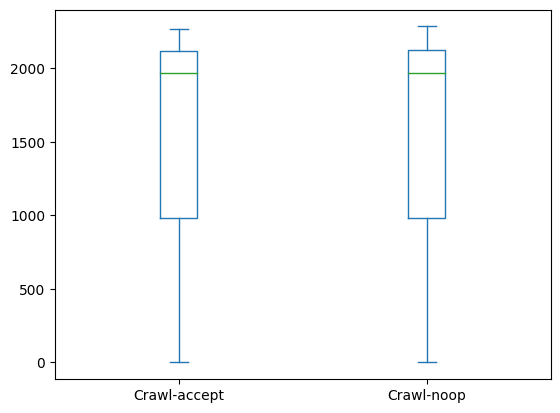

In [99]:
load_time_accept = []
load_time_noop = []

def page_load_time(data):
    time = data['pageLoadEndTimestamp'] - data['pageLoadStartTimestamp'] 
    return (time)

def fill_page_load_lists(accept_list,noop_list ):
    for crawl_accept in accept_list:
        load_time_accept.append(page_load_time(crawl_accept))
    for crawl_noop in noop_list:
        load_time_noop.append(page_load_time(crawl_noop))


fill_page_load_lists(accept_list,noop_list )
print (load_time_accept )
print (load_time_noop )
page_load_time_boxplot = { 'Crawl-accept': load_time_accept , 'Crawl-noop': load_time_noop}


df = pd.DataFrame(page_load_time_boxplot)
df.plot(kind='box')


##### b. Number of requests


[1, 0, 21]
[1, 0, 6]


<Axes: >

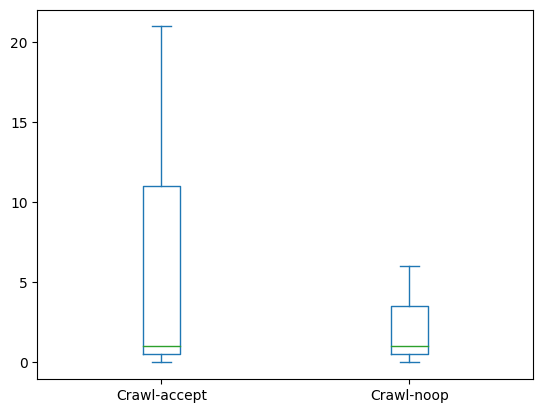

In [100]:
nr_request_data_noop = []
nr_request_data_accept = [] 

def num_requests(data):
    return len(data['httpRequests'])

def fill_request_lists(accept_list,noop_list):
    for crawl_accept in accept_list:
        nr_request_data_accept.append(num_requests(crawl_accept))
    for crawl_noop in noop_list:
        nr_request_data_noop.append(num_requests(crawl_noop))

fill_request_lists(accept_list,noop_list)
request_boxplot = { 'Crawl-accept': nr_request_data_accept, 'Crawl-noop': nr_request_data_noop}

print (nr_request_data_accept)
print (nr_request_data_noop)

df = pd.DataFrame(request_boxplot)
df.plot(kind='box')


    

##### c. Number of distinct third parties

<Axes: >

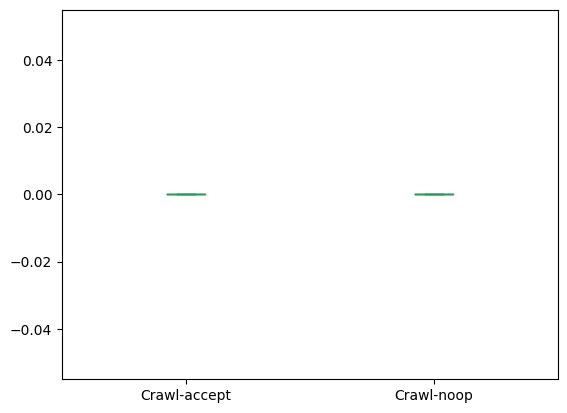

In [101]:
nr_distinct_third_party_accept = []
nr_distinct_third_party_noop = []


def distinct_third_parties(requests,main_domain):
    third_parties = set()
    for request in requests:
        url = request['requestURL']
        req_domain = get_fld(url)
        if req_domain not in main_domain:
            third_parties.add(req_domain)
    return len(third_parties)  
        

def fill_distinct_list(accept_list,noop_list):
    for crawl_accept in accept_list:
        website_domain = crawl_accept['domain'] 
        nr_distinct_third_party_accept.append(distinct_third_parties(crawl_accept['httpRequests'], website_domain)) 
    for crawl_noop in noop_list:
        website_domain = crawl_noop['domain'] 
        nr_distinct_third_party_noop.append(distinct_third_parties(crawl_noop['httpRequests'], website_domain))

fill_distinct_list(accept_list,noop_list)
third_party_boxplot = { 'Crawl-accept': nr_distinct_third_party_accept , 'Crawl-noop': nr_distinct_third_party_noop}


df = pd.DataFrame(third_party_boxplot)
df.plot(kind='box')

## er zijn alleen maar requests van hetzelfde domain in de huidige data

##### d. Number of distinct tracker domains


##### e. Number of distinct tracker entities/companies

### 3: Comparison Crawl-accept vs Crawl-noop (table)

### 4: Table of the Ten most prevalent third-party domains 
##### (based on the number of distinct websites where the third party is present)

In [102]:
cookies = {}
is_tracker = {}
# domain : (nr. of occurrences in accept, nr. of occurrences in noop)

def increment_accept(tuple):
    return ((tuple[0]+1, tuple[1]))

def increment_noop(tuple):
    return ((tuple[0], tuple[1]+1))

def add_distinct_cookies(list, mode):
    for entry in list:
        if entry['cookies']:
            entry_cookies = []
            for cookie in entry['cookies']:
                if cookie['domain'] not in entry_cookies:
                    if mode == 'accept':
                        cookies[cookie['domain']] = increment_accept(cookies.get(cookie['domain'], (0,0)))
                    elif mode == 'noop':
                        cookies[cookie['domain']] = increment_noop(cookies.get(cookie['domain'], (0,0)))
                    entry_cookies.append(cookie['domain'])

add_distinct_cookies(accept_list, 'accept')
add_distinct_cookies(noop_list, 'noop')

top10 = sorted(cookies.items(), key=lambda x:-x[1][0])[:10]

with open("entities.json", "r", encoding="utf8") as tracker_file:
    file_contents = tracker_file.read()
trackers = json.loads(file_contents)['entities']
for tracker in trackers:
    if trackers[tracker]['properties']:
        for domain in trackers[tracker]['properties']:
            for item in top10:
                if domain == item[0]:
                    is_tracker[domain] = "Yes"

empty_third_party_table = {'Third-party domain' : [x[0] for x in top10], 
                           'Crawl-accept':[0]*len(top10),
                           'Crawl-noop': [0]*len(top10),
                           'isTracker?': ["No"]*len(top10)}

# Disable chained assignment warnings
pd.options.mode.chained_assignment = None

third_party_table = pd.DataFrame(empty_third_party_table).set_index('Third-party domain')
for entry in top10:
    third_party_table['Crawl-accept'][entry[0]] = entry[1][0]
    third_party_table['Crawl-noop'][entry[0]] = entry[1][1]
    third_party_table['isTracker?'][entry[0]] = is_tracker.get(entry[0], "No")

print(third_party_table)
    

                    Crawl-accept  Crawl-noop isTracker?
Third-party domain                                     
.google.com                    1           1         No


### 5: Scatter plot of:
##### Y: Number of distinct tracker domains
##### VS
##### X: Website’s Tranco rank
###### (for each crawl)

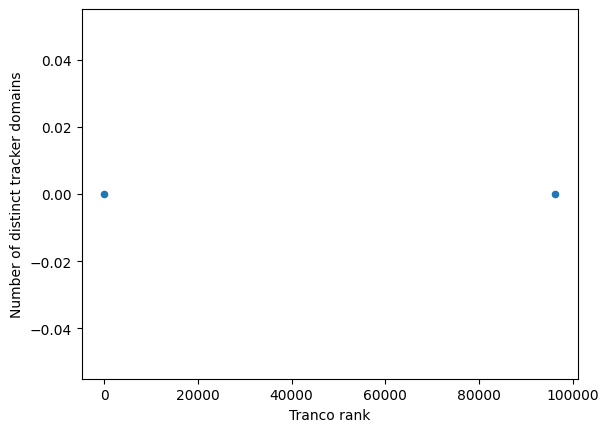

In [125]:
tranco = {}
distinct_trackers = {}

def check_if_tracker(cookie_domain):
    for tracker in trackers:
        if trackers[tracker]['properties']:
            for domain in trackers[tracker]['properties']:
                if domain == cookie_domain:
                    return True
    return False    

for entry in accept_list:
    distinct_trackers[entry['domain']] = 0
    if entry['cookies']:
        entry_cookies = []
        for cookie in entry['cookies']:
            if cookie['domain'] not in entry_cookies:
                entry_cookies.append(cookie['domain'])
                if check_if_tracker(cookie['domain']):
                    distinct_trackers[entry['domain']] += 1
    
import csv   
with open('top-1m.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        for entry in accept_list:
            if row[1] == entry['domain']:
                tranco[entry['domain']] = row[0]
    
tranco_tracker = []
for entry in tranco:
    tranco_tracker.append([int(tranco[entry]), int(distinct_trackers[entry])])
    
df = pd.DataFrame(tranco_tracker, columns=['Tranco rank', 'Number of distinct tracker domains'])
ax1 = df.plot.scatter(x='Tranco rank', y='Number of distinct tracker domains')

### 6: Table of the Top ten tracker entities (companies) and their prevalence
##### (based on the number of distinct websites where the entity is present). Similar to the table in 4, but should only contain tracker entities).

In [144]:
tracker_entities = {}
cookies["exaccess.ru"] = (0,0)
cookies["webmoney.ru"] = (0,0)
cookies["maximonline.ru"] = (0,0)


with open("domain_map.json", "r", encoding="utf8") as domain_map_file:
    domain_map = json.loads(domain_map_file.read())
    for cookie in cookies:
        if cookie in domain_map:
            tracker_entities[domain_map[cookie]['displayName']] = tracker_entities.get(domain_map[cookie]['displayName'], 0) + 1

top10_trackers = sorted(tracker_entities.items(), key=lambda x:-x[1])[:10]
print(top10_trackers)
    
empty_tracker_table = {'Entity name' : [x[0] for x in top10_trackers],
                       'Number of distinct websites': [0]*len(top10_trackers)}
tracker_table = pd.DataFrame(empty_tracker_table).set_index('Entity name')
for entry in top10_trackers:
    tracker_table['Number of distinct websites'][entry[0]] = entry[1]
    
# empty_third_party_table = {'Third-party domain' : [x[0] for x in top10], 
#                            'Crawl-accept':[0]*len(top10),
#                            'Crawl-noop': [0]*len(top10),
#                            'isTracker?': ["No"]*len(top10)}

# # Disable chained assignment warnings
# pd.options.mode.chained_assignment = None

# third_party_table = pd.DataFrame(empty_third_party_table).set_index('Third-party domain')
# for entry in top10:
#     third_party_table['Crawl-accept'][entry[0]] = entry[1][0]
#     third_party_table['Crawl-noop'][entry[0]] = entry[1][1]
#     third_party_table['isTracker?'][entry[0]] = is_tracker.get(entry[0], "No")

[('"Computing Forces" CJSC', 2), ('HS Publishing', 1)]


### 7: Find the three cookies with the longest lifespans **for each crawl**
##### Add a separate table for each crawl having the following columns (see assignment). Only include the first 5 characters of the Value attribute.

### 8: Find the three requests with the most cookies **for each crawl**

### 9: Identify ten most common cross-domain HTTP redirection pairs 
#### that involve a tracker domain either in the source or the target(or both)

### 10: Capture the Images drawn by the canvas fingerprinting scripts
#### Create a table (see assignment)